In [ ]:
from glob import glob

import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
from natsort import natsorted
from shapely.geometry import Point, Polygon

from seisnet.utils import (get_data_dir, get_repo_dir, iou_datasets,
                           load_picks_within_radius)

In [3]:
files = natsorted(glob(f"{get_data_dir()}/train_npz/*.npz"))

In [4]:
seps = [2000,1750,1500,1250,1000,750,500,250,100]
ious = []

for sep_dist_m in seps:
    seed= 32
    # Sparse sampling
    sparse = load_picks_within_radius(f"{get_data_dir()}/train_npz", 
                                      f"{get_data_dir()}/metadata/picks.csv", 
                                      distance=sep_dist_m, seed=seed)
    data_size = len(sparse)
    # Random sampling
    rng = np.random.default_rng(seed)
    random = rng.choice(files, data_size, replace=False)

    iou = iou_datasets(random.tolist(),sparse)
    ious.append(iou)

### Create plot

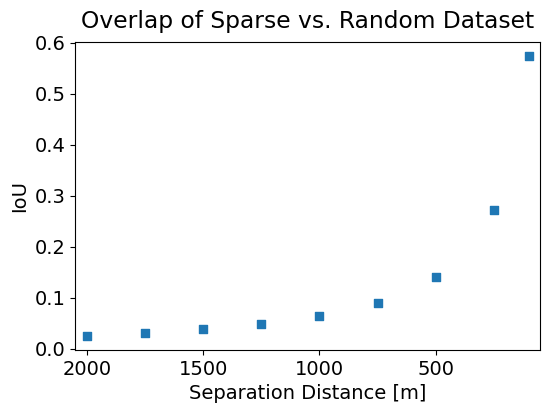

In [ ]:

with plt.rc_context({"font.size":14}):
    plt.figure(figsize=(6,4))
    plt.scatter(seps,ious,marker="s")
    plt.xlim(2050,50)
    plt.xlabel("Separation Distance [m]")
    plt.ylabel("IoU")
    plt.title("Overlap of Sparse vs. Random Dataset",pad=10)
    plt.savefig(f"{get_repo_dir()}/figures/data_iou.png",
                dpi=200,edgecolor="none",bbox_inches="tight")
    plt.show()

In [ ]:

def polygons_from_hexbins(collection):
    """convert hex bins to geopandas with data column"""
    hex_polys = collection.get_paths()[0].vertices
    hex_array = []
    for xs,ys in collection.get_offsets():
        hex_x = np.add(hex_polys[:,0],  xs)
        hex_y = np.add(hex_polys[:,1],  ys)
        hex_array.append(Polygon(np.vstack([hex_x, hex_y]).T))

    counts = collection.get_array()
    return gpd.GeoDataFrame({'count': counts, 'geometry':hex_array})

### Image for random vs. sparse sampling approach

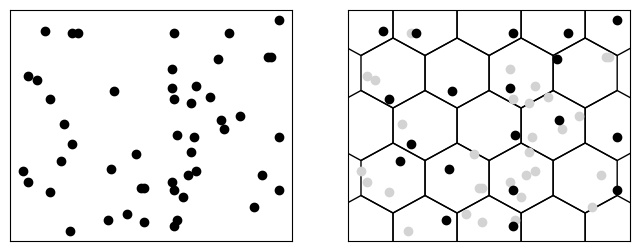

In [69]:
np.random.seed(35)
xx = np.random.randint(0,100,50)/10
yy = np.random.randint(0,100,50)/10

fig,ax = plt.subplots(1,2,figsize=(8,3),sharex=True,sharey=True)

# Plot the original scatter points
ax[0].scatter(xx,yy,c="k")


# Hexbin plot
hb = ax[1].hexbin(xx, yy, gridsize=4, edgecolors="k", facecolors="none")
# ax[1].set_title("Hexbin Overlay")

# Create GeoDataFrame of hex bins
hex_gdf = polygons_from_hexbins(hb)

# Create GeoDataFrame of points
points_gdf = gpd.GeoDataFrame(geometry=[Point(x, y) for x, y in zip(xx, yy)])

# Spatial join: which point falls into which hex
joined = gpd.sjoin(points_gdf, hex_gdf, predicate='within', how='left')

# Group points by hex cell and plot them
grouped = joined.groupby('index_right')

for idx, group in grouped:
    first = group.iloc[0].geometry
    rest = group.iloc[1:].geometry if len(group) > 1 else []
    
    if len(rest) > 0:
        rest_xy = np.array([[pt.x, pt.y] for pt in rest])
        ax[1].scatter(rest_xy[:, 0], rest_xy[:, 1], c='lightgray')
    
    ax[1].scatter(first.x, first.y, c='k')  # first point in black

# Toggle off tick labels
for _ in ax:
    _.set_xticks([]),_.set_yticks([])


plt.savefig(f"{get_repo_dir()}/figures/rand_vs_sparse_approach.png",
            dpi=200,edgecolor="none",bbox_inches="tight")
plt.show()